In [2]:
%load_ext autoreload
%autoreload 2

In [48]:
from embcomp.test_cases.utils import plot
from embcomp.test_cases.neighborhood import plot_neighborhood

def gather_test_cases():
    import embcomp.test_cases.neighborhood as mod
    return [
        getattr(mod, name)
        for name in filter(lambda x: x.startswith("case"), dir(mod))
    ]

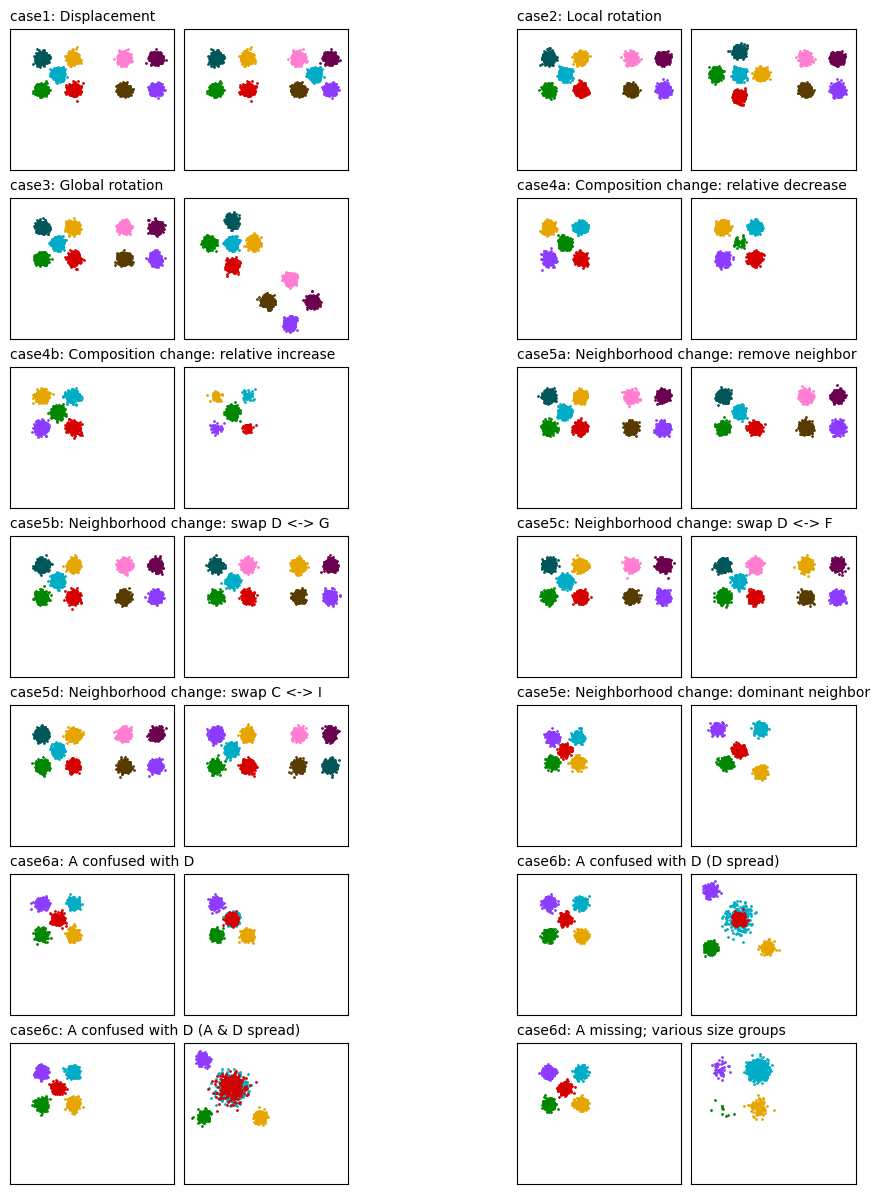

In [49]:
import matplotlib.pyplot as plt
from math import ceil

cases = gather_test_cases()

fig, axs = plt.subplots(ncols=2, nrows=ceil(len(cases) / 2), figsize=(12, 15), sharex=True, sharey=True)

for ax, case in zip(axs.flat, cases):
    ax.set_title(f"{case.__name__}: {case.__doc__}", fontsize='medium', loc='left') 
    plot(*case(), ax=ax)

## Testing

In [75]:
def run(metrics, **kwargs):
    cases = gather_test_cases()
    fig, axs = plt.subplots(nrows=len(cases), ncols=1, **kwargs)
    for ax, case in zip(axs.flat, cases):
        plot_neighborhood(*case(), metrics=metrics, ax=ax)

### Fixed _k_

Axes(0.125,0.833614;0.775x0.0463855)
Axes(0.125,0.777952;0.775x0.0463855)
Axes(0.125,0.722289;0.775x0.0463855)
Axes(0.125,0.666627;0.775x0.0463855)
Axes(0.125,0.610964;0.775x0.0463855)
Axes(0.125,0.555301;0.775x0.0463855)
Axes(0.125,0.499639;0.775x0.0463855)
Axes(0.125,0.443976;0.775x0.0463855)
Axes(0.125,0.388313;0.775x0.0463855)
Axes(0.125,0.332651;0.775x0.0463855)
Axes(0.125,0.276988;0.775x0.0463855)
Axes(0.125,0.221325;0.775x0.0463855)
Axes(0.125,0.165663;0.775x0.0463855)
Axes(0.125,0.11;0.775x0.0463855)


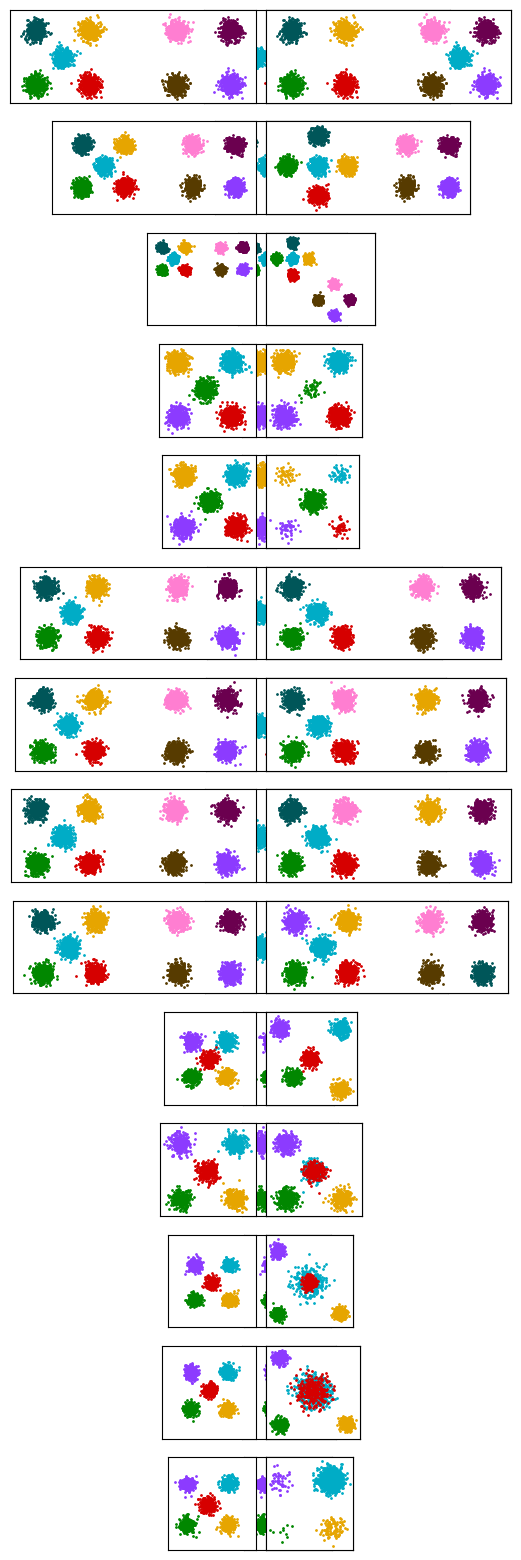

In [76]:
import pandas as pd

def fixed_k(data: pd.DataFrame, k):
    nn = NearestNeighbors(n_neighbors=k).fit(data[["x", "y"]])
    knn_indices = nn.kneighbors(return_distance=False)
    counts = ec.metrics.count_neighbor_labels(knn_indices, data.label)
    index = pd.Series(data.label, name="label", dtype="category")
    df = pd.DataFrame(counts, index=index).groupby("label").sum()
    df.columns = index.cat.categories
    return df


run(metrics=[fixed_k], figsize=(18, 20))